In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from test_function import *
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from test_function import *
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
f = open("/storage/home/jkl5991/group/dbnsfp/tabix_try/backup_noMPC_primateAI/tabixindex.txt") #load index name
header = f.readline().strip().split('\t')
f.close()

omit_model = pd.read_csv("/storage/home/jkl5991/group/dbnsfp/tabix_try/backup_noMPC_primateAI/tabix_omit.tsv", sep = '\t', names = header)
balanced_model = pd.read_csv("/storage/home/jkl5991/group/dbnsfp/tabix_try//backup_noMPC_primateAI/tabix_balanced.tsv", sep = '\t', names = header)


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
omit_model

,chr,pos-1,pos,ref,alt,FATHMM_score,VEST4_score,MetaSVM_score,MetaLR_score,M-CAP_score,REVEL_score,ClinPred_score,LIST-S2_score,CADD_phred_hg19,DANN_score,integrated_fitCons_score,H1-hESC_fitCons_score
0,chr1,865627,865628,G,A,.;.;.;.;.;.;.;.;.;.;.,.;.;0.261;0.243;0.263;0.27;0.459;0.248;0.265;0...,-1.0342,0.0419,.,0.086,0.034906782148642,0.905509;0.907609;0.906909;0.905509;0.906909;0...,20.600,0.985760,0.59774,0.596491
1,chr1,865627,865628,G,T,.;.;.;.;.;.;.;.;.;.;.,.;.;0.412;0.439;0.421;0.483;0.592;0.376;0.409;...,-1.0598,0.0765,0.026357,0.170,0.978160440921783,0.922108;0.923508;0.923908;0.922108;0.923908;0...,23.200,0.996628,0.59774,0.596491
2,chr1,865627,865628,G,C,.;.;.;.;.;.;.;.;.;.;.,.;.;0.35;0.404;0.389;0.417;0.522;0.369;0.363;0...,-1.0704,0.0600,0.018455,0.214,0.982528030872345,0.952205;0.953105;0.953405;0.952205;0.953405;0...,22.700,0.989984,0.59774,0.596491
3,chr1,879480,879481,G,A,.;.;.;.;.;.,0.34;0.231;0.338;0.324;0.223;0.269,-0.5465,0.2735,0.080851,0.550,0.954502284526825,0.834817;0.834817;0.834817;0.834817;0.834817;0...,18.610,0.957814,0.498214,0.578056
4,chr1,879480,879481,G,C,.;.;.;.;.;.,0.429;0.512;0.413;0.527;0.495;0.522,-0.9395,0.0329,.,0.102,0.034695620173236,0.925307;0.925307;0.925307;0.925307;0.925307;0...,17.160,0.991843,0.498214,0.578056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204743,chrY,2655555,2655556,C,G,-4.61,0.126,-0.0613,0.6789,0.997909,0.318,0.140338308938629,0.824517,4.282,0.711543,.,.
204744,chrY,2655555,2655556,C,A,-4.66,0.152,0.3776,0.8153,0.997982,0.608,0.840452134609222,0.915508,15.650,0.958270,.,.
204745,chrY,2655591,2655592,C,G,-4.65,0.179,-0.2587,0.6645,0.997838,0.297,0.0580304496253716,0.69713,5.617,0.737316,.,.
204746,chrY,2655591,2655592,C,T,-4.66,0.657,-0.2672,0.6611,0.997814,0.260,0.0312199041737979,0.732627,8.074,0.753333,.,.


In [3]:
omit = pd.read_csv('unannotated_omit_std.tsv', sep = '\t')
dominant = pd.read_csv('dominant_std.tsv', sep = '\t')
recessive = pd.read_csv("recessive_std.tsv",sep = '\t')

omit_with_criteria = pd.read_csv('omit_with_criteria.tsv', sep = '\t')

In [4]:
def merge_with_original_df(originaldf, newdf):
    newdf['location'] = newdf['chr'] + '-' + newdf['pos-1'].map(str)+ '-' + newdf['pos'].map(str)+ '-' + newdf['ref'].map(str)+ '-' + newdf['alt'].map(str)
    result = pd.merge(originaldf, newdf, on=['location'])
    result = result.drop(columns = ['chr', 'pos-1', 'pos', 'ref', 'alt'])
    return(result)

In [5]:
def fitting_gb(Xtrain, ytrain, Xtest, ytest, learning, depth, estimator, randomseed =42):
    #np.random.seed(randomseed)
    model = GradientBoostingClassifier(learning_rate = learning, max_depth = depth, n_estimators = estimator, subsample = 1)
    
    model.fit(Xtrain, ytrain)
    
    model_pred = model.decision_function(Xtest)
    
    return(ytest, model_pred, model)


In [6]:
def drawROC(ytest, ytest_hat, lw=2, linestyle = '--', label = '', lastone = False, MoreThanOnelocation = 'lower right', fontsize = 12, title = '', legendloc = ''):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label + ', (AUC = %0.3f)'%roc_auc)
    if (lastone == True):
        plt.legend(bbox_to_anchor= (1.1, 1.0))
   
        plt.title(title)
        plt.show()

In [7]:
def tun_gb(Xtrain, ytrain, tuned_parameters):
    np.random.seed(42)
    clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring='%s_macro' % 'recall')
    clf.fit(Xtrain, ytrain)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("With score : %0.3f\n"%clf.best_score_)
    print("Grid scores on development set:\n")
    return(clf.best_params_)

In [8]:
def split(df, Xname, Yname, testsize = 0.1):
    if(type(Xname) == list):
        for i in Xname:
            df.drop(df.loc[df[i] == '.'].index, inplace= True)
        X = df.loc[:,Xname]       
    else:
        df.drop(df.loc[df[Xname] == '.'].index, inplace= True)
        #df.drop(df.loc[df[Xname].str.contains(';')], inplace= True)
        X = df.loc[:,[Xname]]
        #df = df.loc[df[Xname].str.contains('1.|0.', na=False)]
        #df = df[~df[Xname].str.contains(';', na=False)]
    y = df.loc[:,[Yname]].values.flatten()
    
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = testsize, random_state = 42)    
    Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain,ytrain, test_size = 0.11, random_state = 42)
    
    return(Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest, df)




In [9]:
original_column = ['SIFT_pred','LRT_pred', 'MA_pred', 'PROVEN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver',
                   'RNA_seq','UNEECON']


features = ['MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'REVEL_score','ClinPred_score','CADD_phred_hg19',
            'DANN_score','integrated_fitCons_score','H1-hESC_fitCons_score']


allcolumn = original_column + features

In [10]:
def compare(original, others, title, originalcolumn = original_column, newfeatures = features, allcolumnname = allcolumn):
    new = merge_with_original_df(original,others)
    new_split = split(new, allcolumnname, 'clinvar_result')
    Xtrain = new_split[0].loc[:,original_column]
    Xvalid = new_split[1].loc[:,original_column]
    Xtest = new_split[2].loc[:,original_column]

    tuned_parameters = {"learning_rate" : [0.05,0.1,0.15], 
                   "n_estimators": [100,150,200],
                    "max_depth": [3,5,8]}
    
    print('training set = %d,\ntesting set = %d,\nvalidation set = %d'%(Xtrain.shape[0], Xtest.shape[0], Xvalid.shape[0]))
   
    
    para = tun_gb(Xvalid, new_split[4], tuned_parameters)
    
    
    fit_gb = fitting_gb(Xtrain, new_split[3], Xtest, new_split[5], para['learning_rate'], para['max_depth'],para['n_estimators'])
    
    
    for i in newfeatures:
        score = new_split[2][i].values.astype(float)
        drawROC(new_split[5], score, label = i)

    
    drawROC(fit_gb[0], fit_gb[1], label = "original", lw = 4, linestyle = '-', lastone = True, title = title)
    return(Xtrain, Xvalid, Xtest, new_split[3], new_split[4], new_split[5])
    

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


training set = 1107,
testing set = 139,
validation set = 137


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
With score : 0.784

Grid scores on development set:



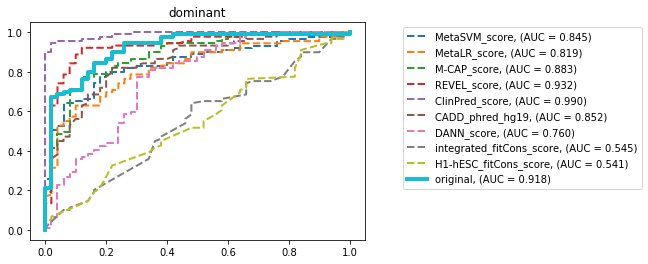

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


training set = 1185,
testing set = 149,
validation set = 147


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
With score : 0.774

Grid scores on development set:



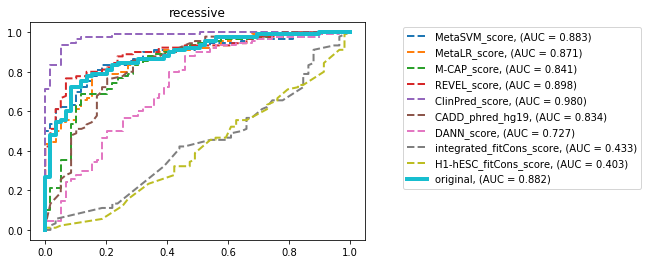

In [11]:
dominant_test = compare(dominant, balanced_model, 'dominant')
recesssive_test = compare(recessive, balanced_model, 'recessive')

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


training set = 37476,
testing set = 4679,
validation set = 4632


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
With score : 0.836

Grid scores on development set:



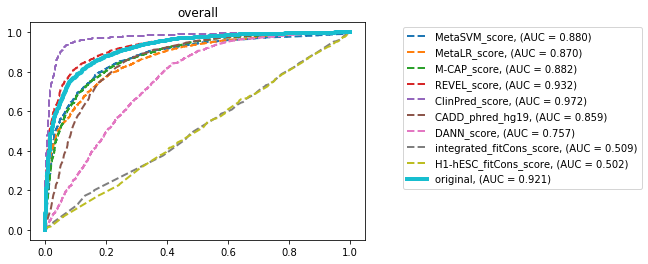

In [13]:
omit_test = compare(omit, omit_model, "overall")

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


training set = 22844,
testing set = 2852,
validation set = 2824


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 150}
With score : 0.845

Grid scores on development set:



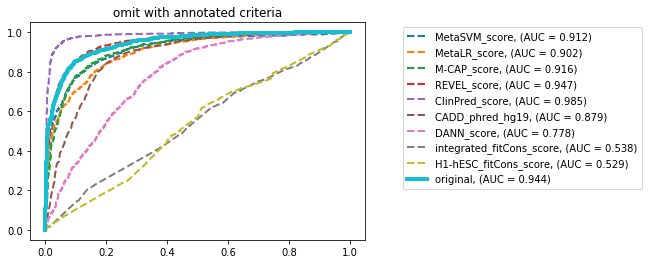

In [12]:
# remove assertion criteria not provided data

omit_test_annotated = compare(omit_with_criteria, omit_model, "omit with annotated criteria")

In [17]:
# output file
new = merge_with_original_df(omit, omit_model)

In [22]:
new

,location,accession_num,clinvar_result,SIFT_pred,LRT_pred,MA_pred,PROVEN_pred,SLR_score,SIFT_score,LRT_omega,...,MetaSVM_score,MetaLR_score,M-CAP_score,REVEL_score,ClinPred_score,LIST-S2_score,CADD_phred_hg19,DANN_score,integrated_fitCons_score,H1-hESC_fitCons_score
2,chr1-891392-891393-G-A,ENSG00000188976.6|NOC2L,0,0,0,0,0,0.017887,3.501810,-0.028677,...,-0.9871,0.0518,0.117497,0.168,0.011943571039473,0.591441,18.710,0.609726,0.706548,0.724815
3,chr1-897008-897009-A-G,ENSG00000187961.9|KLHL17,0,0,0,0,0,0.017887,1.453542,-0.028267,...,-0.9254,0.0870,0.025404,0.199,0.0632387617366854,0.910909,17.800,0.757441,0.740716,0
8,chr1-909368-909369-G-A,ENSG00000187583.6|PLEKHN1,0,0,0,0,0,0.017887,-0.131771,-0.020771,...,-1.0285,0.0329,0.006359,0.007,0.00095296365922228,0.230077;0.230077;0.230077;0.230077,8.064,0.769905,0.554377,0.576033
11,chr1-949780-949781-G-A,ENSG00000187608.5|ISG15,0,0,0,0,0,0.669956,-0.248541,-0.017137,...,-0.9933,0.1007,0.022658,0.105,0.0108842688065922,0.579442;0.579442;.;0.579442,14.870,0.972044,0.72623,0.594344
12,chr1-949850-949851-G-C,ENSG00000187608.5|ISG15,0,1,0,0,0,0.017887,-0.466967,-0.002654,...,-1.0223,0.0232,0.002278,0.012,0.00471755551842255,0.453055;.;0.453055,0.014,0.671454,0.741868,0.774882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65840,chr9-140972615-140972616-A-G,ENSG00000148408.8|CACNA1B,0,1,0,0,0,0.017887,-0.182012,-0.025956,...,0.0282,0.6664,0.017098,0.295,0.035915727216768,0.810419;0.810419;0.810419;0.810419;0.810419;0...,18.280,0.990728,0.615465,0.658983
65841,chr9-141014680-141014681-C-G,ENSG00000148408.8|CACNA1B,0,0,0,0,0,0.017887,2.937197,-0.013167,...,-0.8866,0.1556,0.028038,0.139,0.000611134341276617,0.340666;0.340666;0.340666;0.340666;0.340666;0...,0.233,0.383779,0.646311,0.645312
65842,chr9-141015292-141015293-C-T,ENSG00000148408.8|CACNA1B,0,1,0,1,1,0.017887,-0.382482,-0.024591,...,0.8125,0.8982,0.071272,0.368,0.0662782645373202,0.853715;0.853715;0.853715;0.853715;0.853715;0...,22.400,0.997899,0.646311,0.645312
65843,chr9-141016270-141016271-C-T,ENSG00000148408.8|CACNA1B,0,1,0,0,0,0.017887,-0.619453,0.000248,...,0.5530,0.8611,0.21968,0.609,0.0417342519219338,0.39496;0.39496,8.284,0.979116,0.646311,0.645312


In [24]:
output = split(new, allcolumn, 'clinvar_result')[6]

In [25]:
output.to_csv('/storage/home/jkl5991/work/project/not_conflict/all_model.tsv', sep = '\t',index = False)

In [26]:
output

,location,accession_num,clinvar_result,SIFT_pred,LRT_pred,MA_pred,PROVEN_pred,SLR_score,SIFT_score,LRT_omega,...,MetaSVM_score,MetaLR_score,M-CAP_score,REVEL_score,ClinPred_score,LIST-S2_score,CADD_phred_hg19,DANN_score,integrated_fitCons_score,H1-hESC_fitCons_score
2,chr1-891392-891393-G-A,ENSG00000188976.6|NOC2L,0,0,0,0,0,0.017887,3.501810,-0.028677,...,-0.9871,0.0518,0.117497,0.168,0.011943571039473,0.591441,18.710,0.609726,0.706548,0.724815
3,chr1-897008-897009-A-G,ENSG00000187961.9|KLHL17,0,0,0,0,0,0.017887,1.453542,-0.028267,...,-0.9254,0.0870,0.025404,0.199,0.0632387617366854,0.910909,17.800,0.757441,0.740716,0
8,chr1-909368-909369-G-A,ENSG00000187583.6|PLEKHN1,0,0,0,0,0,0.017887,-0.131771,-0.020771,...,-1.0285,0.0329,0.006359,0.007,0.00095296365922228,0.230077;0.230077;0.230077;0.230077,8.064,0.769905,0.554377,0.576033
11,chr1-949780-949781-G-A,ENSG00000187608.5|ISG15,0,0,0,0,0,0.669956,-0.248541,-0.017137,...,-0.9933,0.1007,0.022658,0.105,0.0108842688065922,0.579442;0.579442;.;0.579442,14.870,0.972044,0.72623,0.594344
12,chr1-949850-949851-G-C,ENSG00000187608.5|ISG15,0,1,0,0,0,0.017887,-0.466967,-0.002654,...,-1.0223,0.0232,0.002278,0.012,0.00471755551842255,0.453055;.;0.453055,0.014,0.671454,0.741868,0.774882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65840,chr9-140972615-140972616-A-G,ENSG00000148408.8|CACNA1B,0,1,0,0,0,0.017887,-0.182012,-0.025956,...,0.0282,0.6664,0.017098,0.295,0.035915727216768,0.810419;0.810419;0.810419;0.810419;0.810419;0...,18.280,0.990728,0.615465,0.658983
65841,chr9-141014680-141014681-C-G,ENSG00000148408.8|CACNA1B,0,0,0,0,0,0.017887,2.937197,-0.013167,...,-0.8866,0.1556,0.028038,0.139,0.000611134341276617,0.340666;0.340666;0.340666;0.340666;0.340666;0...,0.233,0.383779,0.646311,0.645312
65842,chr9-141015292-141015293-C-T,ENSG00000148408.8|CACNA1B,0,1,0,1,1,0.017887,-0.382482,-0.024591,...,0.8125,0.8982,0.071272,0.368,0.0662782645373202,0.853715;0.853715;0.853715;0.853715;0.853715;0...,22.400,0.997899,0.646311,0.645312
65843,chr9-141016270-141016271-C-T,ENSG00000148408.8|CACNA1B,0,1,0,0,0,0.017887,-0.619453,0.000248,...,0.5530,0.8611,0.21968,0.609,0.0417342519219338,0.39496;0.39496,8.284,0.979116,0.646311,0.645312


In [ ]:
# output2 (not included MPC and primateAI)
#tabix output2.bed.bgz -R non_ssc_sortedloc.bed > tabix_non_ssc_othermodel.tsv